<a href="https://colab.research.google.com/github/giacomobinco/FDS-Final-Project/blob/main/fma_dataset5856%20VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.image as mpimg
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms, datasets


In [2]:
# Cloning the GitHub repos of the "fma_small" dataset and the metadata
# [ !! It takes about 5 minutes !! ]

!wget https://os.unil.cloud.switch.ch/fma/fma_small.zip
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2025-12-14 09:58:40--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip       100%[===================>]   7.15G  20.0MB/s    in 6m 14s  

2025-12-14 10:04:55 (19.6 MB/s) - ‘fma_small.zip’ saved [7679594875/7679594875]

--2025-12-14 10:04:55--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81

In [3]:
# Unzipping the two folders previously loaded
# [ !! It takes about 15 minutes !! ]

for zip_path in ["fma_small.zip", "fma_metadata.zip"]:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall()

In [4]:
AUDIO_DIR = "fma_small"
files = []

for root, dirs, filenames in os.walk(AUDIO_DIR):
    for f in filenames:
        if f.lower().endswith(".mp3"):
            files.append(os.path.join(root, f))

print(f"{len(files)} file MP3 trovati")
print(files[:5])


8000 file MP3 trovati
['fma_small/142/142359.mp3', 'fma_small/142/142097.mp3', 'fma_small/142/142567.mp3', 'fma_small/142/142096.mp3', 'fma_small/142/142571.mp3']


In [5]:
# Generating four tables (from the metadata) with information regarding the 8.000 audio tracks

tracks = pd.read_csv('fma_metadata/tracks.csv', index_col = 0, header = [0, 1])
genres = pd.read_csv('fma_metadata/genres.csv', index_col = 0)
features = pd.read_csv('fma_metadata/features.csv', index_col = 0, header = [0, 1, 2])
echonest = pd.read_csv('fma_metadata/echonest.csv', index_col = 0, header = [0, 1, 2])

# Printing their shape to check if they've been correctly generated

print("Tracks:", tracks.shape)
print("Genres:", genres.shape)
print("Features:", features.shape)
print("Echonest:", echonest.shape)

Tracks: (106574, 52)
Genres: (163, 4)
Features: (106574, 518)
Echonest: (13129, 249)


ChatGPT regarding the file *features.csv*:

"Sono feature pre-estratte dall’audio usando *librosa*, ma non sono spettrogrammi completi. Non sono dunque adatte per CNN: non sono matrici tempo-frequenza, quanto più valori aggregati."

In [6]:
audio_dir = "fma_small"
files = []

for root, dirs, filenames in os.walk(audio_dir):
    for f in filenames:
        if f.endswith(".mp3"):
            files.append(os.path.join(root, f))

print(f"----- {len(files)} audio tracks found -----")


----- 8000 audio tracks found -----


In [7]:
#UPLOADING THE SPECTOGRAM FOLDER
zip_path = "fma_spectrograms.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("fma_spectrograms")
print("✓ ZIP estratto con successo!")



✓ ZIP estratto con successo!


In [8]:
# Cartella dove vogliamo estrarre le immagini
OUTPUT_DIR = "fma_spectrograms_clean"
os.makedirs(OUTPUT_DIR, exist_ok=True)

with zipfile.ZipFile("fma_spectrograms.zip", "r") as zip_ref:
    # ZIP potrebbe contenere una cartella interna
    for member in zip_ref.namelist():
        # Rimuove eventuale cartella interna (solo il nome del file)
        filename = os.path.basename(member)
        if filename:  # evita le cartelle vuote
            # Scrive direttamente nella nostra cartella OUTPUT_DIR
            source = zip_ref.open(member)
            target_path = os.path.join(OUTPUT_DIR, filename)
            with open(target_path, "wb") as target:
                with source as src:
                    target.write(src.read())

# Controllo
print("Prime immagini estratte:", os.listdir(OUTPUT_DIR)[:5])


Prime immagini estratte: ['10441_Folk.png', '127541_Experimental.png', '83790_Rock.png', '108837_Hip-Hop.png', '80000_Folk.png']


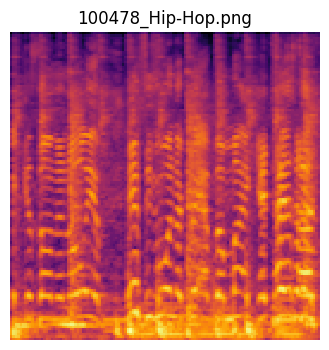

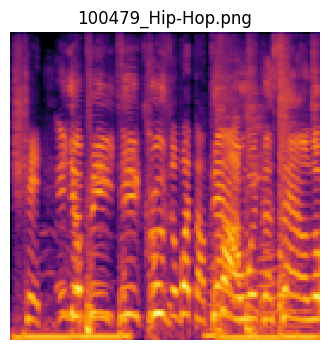

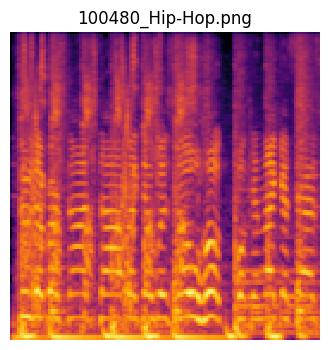

In [9]:
img_files = sorted(os.listdir(OUTPUT_DIR))[:3]

for img_file in img_files:
    img_path = os.path.join(OUTPUT_DIR, img_file)
    img = mpimg.imread(img_path)

    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file)
    plt.show()



In [10]:
#CNN works better if the dataset is organized in folders
#Folder Organization
spectrogram_dir = "fma_spectrograms_clean"
dataset_dir = "dataset"
os.makedirs(dataset_dir, exist_ok=True)

tracks = pd.read_csv("fma_metadata/tracks.csv", index_col=0, header=[0,1])

copied = 0
skipped = 0

for fname in os.listdir(spectrogram_dir):
    if not fname.lower().endswith(".png"):
        continue

    track_id_str = fname.split("_")[0]

    try:
        track_id = int(track_id_str)
    except:
        skipped += 1
        continue

    if track_id not in tracks.index:
        skipped += 1
        continue

    genre = tracks.loc[track_id, ('track','genre_top')]
    genre_dir = os.path.join(dataset_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)

    shutil.copy(os.path.join(spectrogram_dir, fname), os.path.join(genre_dir, fname))
    copied += 1

print(f"✅ Copiati {copied} file nelle cartelle dei generi")
print(f"⚠️ Saltati {skipped} file senza corrispondenza")




✅ Copiati 7997 file nelle cartelle dei generi
⚠️ Saltati 0 file senza corrispondenza


In [11]:
#Check if the file are distrbituited correctly
for genre in sorted(os.listdir(dataset_dir)):
    genre_path = os.path.join(dataset_dir, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)[:5]
        print(f"{genre}: {files}")


Electronic: ['33216_Electronic.png', '54719_Electronic.png', '105412_Electronic.png', '84200_Electronic.png', '147780_Electronic.png']
Experimental: ['127541_Experimental.png', '74960_Experimental.png', '109548_Experimental.png', '49407_Experimental.png', '40909_Experimental.png']
Folk: ['10441_Folk.png', '80000_Folk.png', '5879_Folk.png', '106342_Folk.png', '142129_Folk.png']
Hip-Hop: ['108837_Hip-Hop.png', '141735_Hip-Hop.png', '75929_Hip-Hop.png', '64516_Hip-Hop.png', '130454_Hip-Hop.png']
Instrumental: ['126321_Instrumental.png', '115773_Instrumental.png', '134449_Instrumental.png', '14572_Instrumental.png', '126231_Instrumental.png']
International: ['3895_International.png', '73763_International.png', '107187_International.png', '6363_International.png', '135222_International.png']
Pop: ['10806_Pop.png', '46846_Pop.png', '113935_Pop.png', '141182_Pop.png', '62436_Pop.png']
Rock: ['83790_Rock.png', '124186_Rock.png', '122088_Rock.png', '135371_Rock.png', '3840_Rock.png']


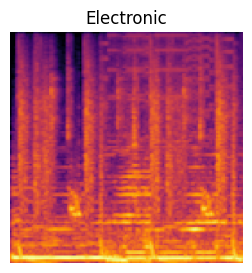

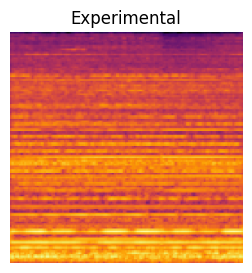

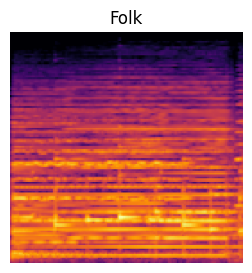

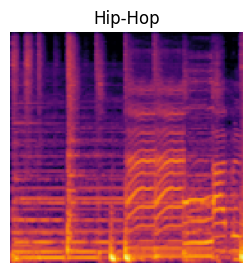

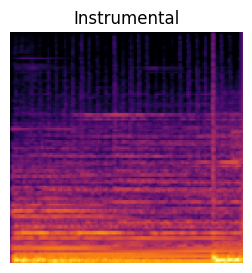

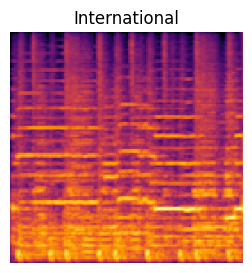

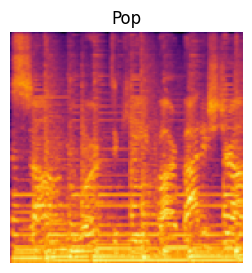

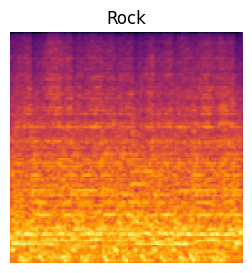

In [11]:
#Visualization of one image per genre
for genre in sorted(os.listdir(dataset_dir)):
    genre_path = os.path.join(dataset_dir, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)
        if files:
            img_path = os.path.join(genre_path, files[0])
            img = mpimg.imread(img_path)
            plt.figure(figsize=(6,3))
            plt.imshow(img)
            plt.axis('off')
            plt.title(genre)
            plt.show()


We can clearly see that all  the spectrograms, besides the one for the "Rock" genre, are quite similar.
The spectrogram rapresenting a "Rock" song is clearly not as noisy as the spectrograms rapresenting all the other genres

In [27]:
# ============================================================
# COMPLETE, STABLE TRAINING SCRIPT (ViT-B/16 on Spectrograms)
# Strategy:
#  - Warmup (head only)
#  - Full fine-tuning (all layers)
#  - Limited MixUp (early FT only)
#  - Moderate regularization (no over-freeze)
#  - Logs Train/Val loss + accuracy
# ============================================================

import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.amp import autocast, GradScaler

# ------------------------
# DEVICE
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# DATA AUGMENTATION (STABLE)
# ------------------------
class TimeMask:
    def __init__(self, T=40): self.T = T
    def __call__(self, x):
        _, _, W = x.shape
        t = random.randint(0, self.T)
        t0 = random.randint(0, max(0, W - t))
        x[:, :, t0:t0+t] = 0
        return x

class FreqMask:
    def __init__(self, F=30): self.F = F
    def __call__(self, x):
        _, H, _ = x.shape
        f = random.randint(0, self.F)
        f0 = random.randint(0, max(0, H - f))
        x[:, f0:f0+f, :] = 0
        return x

train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224), scale=(0.7,1.0)),
    transforms.ToTensor(),
    transforms.RandomApply([TimeMask(40)], p=0.4),
    transforms.RandomApply([FreqMask(30)], p=0.4),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ------------------------
# DATASET / SPLIT
# ------------------------
dataset_dir = "/content/dataset"
raw_dataset = datasets.ImageFolder(dataset_dir)
num_classes = len(raw_dataset.classes)

indices = list(range(len(raw_dataset)))
random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

train_ds = Subset(datasets.ImageFolder(dataset_dir, transform=train_transform), train_idx)
val_ds   = Subset(datasets.ImageFolder(dataset_dir, transform=val_transform), val_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# ------------------------
# MIXUP (CORRECT)
# ------------------------
def mixup(x, y, alpha=0.4):
    lam = torch.tensor(np.random.beta(alpha, alpha), device=x.device)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx], lam)

def mixup_loss(criterion, preds, targets):
    y1, y2, lam = targets
    return lam*criterion(preds, y1) + (1-lam)*criterion(preds, y2)

# ------------------------
# MODEL
# ------------------------
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(model.heads.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
).to(device)

model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = GradScaler()

# ------------------------
# TRAIN / EVAL FUNCTIONS
# ------------------------
def train_epoch(loader, optimizer, mixup_enabled):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if mixup_enabled:
            x, targets = mixup(x,y)
        else:
            targets = None

        with autocast(device_type='cuda'):
            preds = model(x)
            loss = mixup_loss(criterion, preds, targets) if targets else criterion(preds, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item()
        if targets is None:
            correct += (preds.argmax(1)==y).sum().item()
            total += y.size(0)

    acc = 100*correct/total if total>0 else 0
    return loss_sum/len(loader), acc

@torch.no_grad()
def evaluate(loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with autocast(device_type='cuda'):
            preds = model(x)
            loss = criterion(preds,y)
        loss_sum += loss.item()
        correct += (preds.argmax(1)==y).sum().item()
        total += y.size(0)
    return loss_sum/len(loader), 100*correct/total

# ============================================================
# TRAINING LOOP
# ============================================================
best_val_acc = 0.0
best_wts = copy.deepcopy(model.state_dict())

# -------- WARMUP (4 EPOCHS) --------
for p in model.parameters(): p.requires_grad = False
for p in model.heads.parameters(): p.requires_grad = True

optimizer = optim.AdamW(model.heads.parameters(), lr=1e-3, weight_decay=0.005)

print("\n🔥 WARMUP: Linear Probing (Solo Head)")
for ep in range(1,5):
    tr_l, tr_a = train_epoch(train_loader, optimizer, mixup_enabled=False)
    vl_l, vl_a = evaluate(val_loader)
    print(f"[WARMUP] Ep {ep}/4 | Train {tr_l:.4f} Acc {tr_a:.2f}% | Val {vl_l:.4f} Acc {vl_a:.2f}%")
    if vl_a > best_val_acc:
        best_val_acc = vl_a
        best_wts = copy.deepcopy(model.state_dict())

# -------- FULL FINETUNE (12 EPOCHS) --------
for p in model.parameters(): p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)

print("\n🚀 FULL FINE-TUNING – 12 Epoche")
for ep in range(1,13):
    mixup_on = ep <= 4
    tr_l, tr_a = train_epoch(train_loader, optimizer, mixup_enabled=mixup_on)
    vl_l, vl_a = evaluate(val_loader)
    scheduler.step()

    print(f"[FT] Ep {ep}/12 | Train {tr_l:.4f} Acc {tr_a:.2f}% | Val {vl_l:.4f} Acc {vl_a:.2f}%")

    if vl_a > best_val_acc:
        best_val_acc = vl_a
        best_wts = copy.deepcopy(model.state_dict())

model.load_state_dict(best_wts)
print(f"\n✅ Migliore Validation Accuracy: {best_val_acc:.2f}%")



🔥 WARMUP: Linear Probing (Solo Head)
[WARMUP] Ep 1/4 | Train 1.8060 Acc 35.66% | Val 1.7207 Acc 40.06%
[WARMUP] Ep 2/4 | Train 1.7128 Acc 42.38% | Val 1.6781 Acc 45.56%
[WARMUP] Ep 3/4 | Train 1.6855 Acc 43.04% | Val 1.6790 Acc 44.25%
[WARMUP] Ep 4/4 | Train 1.6816 Acc 42.64% | Val 1.6137 Acc 46.81%

🚀 FULL FINE-TUNING – 12 Epoche
[FT] Ep 1/12 | Train 1.7921 Acc 0.00% | Val 1.5581 Acc 48.94%
[FT] Ep 2/12 | Train 1.6888 Acc 0.00% | Val 1.5340 Acc 49.69%
[FT] Ep 3/12 | Train 1.6595 Acc 0.00% | Val 1.4570 Acc 55.25%
[FT] Ep 4/12 | Train 1.6290 Acc 0.00% | Val 1.4473 Acc 55.44%
[FT] Ep 5/12 | Train 1.4231 Acc 56.82% | Val 1.4363 Acc 54.94%
[FT] Ep 6/12 | Train 1.3745 Acc 58.70% | Val 1.4380 Acc 55.94%
[FT] Ep 7/12 | Train 1.3338 Acc 60.65% | Val 1.4344 Acc 56.50%
[FT] Ep 8/12 | Train 1.2762 Acc 63.33% | Val 1.4155 Acc 57.31%
[FT] Ep 9/12 | Train 1.2147 Acc 66.39% | Val 1.4169 Acc 57.81%
[FT] Ep 10/12 | Train 1.1741 Acc 68.38% | Val 1.4027 Acc 58.38%
[FT] Ep 11/12 | Train 1.1369 Acc 69.75%

5/5 Epoch , Loss: 1.075

In [ ]:
#save
torch.save(model.state_dict(), "cnn_fma.pth")


Accuracy sul validation set: 89.00%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# Make sure model is in evaluation mode
model.eval()

all_labels, all_preds, all_images, all_filenames = [], [], [], []

# Loop through validation set
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu())  # keep images for visualization
        # Normalized confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=dataset.classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

# Visualize misclassified examples for certain genres
misclassified_idx = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]



Most of the wrong prediction are predicting electronic istead of hip hop and pop
Also Experimental has a lot of misprediction